In [16]:
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
import seaborn as sns

import folium
from IPython.display import display

In [17]:
df = pd.read_pickle('../../data/processed/state0/ios_right_df.pkl')
print(df.shape)

(9603, 21)


In [18]:
full_df = df.drop(columns=['eventType', 'eventStart', 'eventEnd'])
print(full_df.columns.tolist())
print(full_df.shape)

['eventSampleSpeed', 'eventDurationSeconds', 'eventMilesDriven', 'eventStartLatitude', 'eventStartLongitude', 'eventEndLatitude', 'eventEndLongitude', 'eventGPSSignalStrength', 'eventStartSpeed', 'eventEndSpeed', 'gpsMedianLateralAccel', 'bearing_angular_change_per_second', 'bearingAngleChange', 'gps_radius', 'dv', 'turn_intensity', 'angle_norm', 'radius_log']
(9603, 18)


In [19]:
features = [
    'bearingAngleChange',
    'bearing_angular_change_per_second',
    'radius_log',
    'turn_intensity',
    'angle_norm'
]
df = full_df[features].copy()
print(df.columns.to_list())
print(df.shape)

['bearingAngleChange', 'bearing_angular_change_per_second', 'radius_log', 'turn_intensity', 'angle_norm']
(9603, 5)


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

In [21]:
def calculate_gini_score(labels) -> float:
    # Exclude HDBSCAN/DBSCAN noise
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() == 0:
        return 0.0
    # Counts per cluster
    counts = np.bincount(labels[mask])
    counts = counts[counts > 0].astype(float)
    if counts.size <= 1:
        return 0.0
    # Pairwise Gini
    G = np.abs(counts[:, None] - counts[None, :]).sum() / (2 * counts.size * counts.sum())
    # Normalize so 1.0 = maximally imbalanced given k clusters
    Gmax = (counts.size - 1) / counts.size
    return float(G / Gmax) if Gmax else 0.0

In [22]:
# k means model
results_list = []
# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(X_scaled)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(X_scaled, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)

    results_list.append({
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k
    })    


In [23]:
N_total = X_scaled.shape[0]

In [24]:
# DBSCAN
for eps in np.linspace(0.1, 2.0, 20):
    for min_pts in range(3, 20):
        labels = DBSCAN(eps=float(eps), min_samples=int(min_pts), n_jobs=-1).fit_predict(X_scaled)
        mask = labels != -1
        labels_nn = labels[mask]
        n_clusters = len(np.unique(labels_nn))
        n_noise = int((labels == -1).sum())
        noise_pct = (n_noise / N_total) * 100.0

        if not (2 <= n_clusters <= 5) or labels_nn.size < 2:
            continue

        sil = silhouette_score(X_scaled[mask], labels_nn)
        gini = calculate_gini_score(labels)
        results_list.append({
            'model': 'dbscan',
            'HP (eps)': float(eps),
            'HP (min_samp)': int(min_pts),
            'clust. #': int(n_clusters),
            'sil. #': float(sil),
            'Gini': float(gini),
            'noise %': float(noise_pct),
        })

In [25]:
# HDBSCAN modeling
for min_samp in [2, 10]:
    for min_cluster_size in range(8, 25):

        if min_samp > min_cluster_size:
            continue

        clusterer = hdbscan.HDBSCAN(min_samples=min_samp, min_cluster_size=min_cluster_size, metric='euclidean')
        clusterer.fit(X_scaled)
        labels = clusterer.labels_
        
        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        n_clusters = len(np.unique(labels_non_noise))

        n_noise = np.sum(labels == -1)
        noise_percentage = (n_noise / N_total) * 100

        sil_score = np.nan
        if noise_percentage < 15 and n_clusters >= 2 and labels_non_noise.size >= 2:
            try:
                sil_score = silhouette_score(X_scaled[non_noise_mask], labels_non_noise)
            except ValueError:
                sil_score = np.nan

        gini_score = calculate_gini_score(labels) 

        results_list.append({
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_cluster_size)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })


/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/connieyang/Do

In [26]:
results_df = pd.DataFrame(results_list).sort_values(by=['noise %', 'Gini', 'sil. #', 'clust. #',], ascending=[True, True, False, False])
filtered_results = results_df.reset_index().rename(columns={'index': 'run_id'})
filtered_results = filtered_results[filtered_results['noise %'] <= 0.15]
filtered_results = filtered_results[(filtered_results['clust. #'] >= 2)]
filtered_results = filtered_results[(filtered_results['sil. #'] >= 0.3)]
print(filtered_results.head(100))

   run_id    model    sil. #      Gini   noise %  clust. #  HP (eps)  \
0       0   kmeans  0.368986  0.014266  0.000000         2       NaN   
1       1   kmeans  0.376447  0.131313  0.000000         3       NaN   
2       3   kmeans  0.368158  0.239561  0.000000         5       NaN   
3       2   kmeans  0.385744  0.297789  0.000000         4       NaN   
4      66  hdbscan  0.754272  0.997497  0.135374         2       NaN   
5      67  hdbscan  0.754272  0.997497  0.135374         2       NaN   
6      68  hdbscan  0.754272  0.997497  0.135374         2       NaN   
7      69  hdbscan  0.754272  0.997497  0.135374         2       NaN   
8      70  hdbscan  0.754272  0.997497  0.135374         2       NaN   

   HP (min_samp)  HP (min_cluster_size)  
0            NaN                    NaN  
1            NaN                    NaN  
2            NaN                    NaN  
3            NaN                    NaN  
4            2.0                    8.0  
5            2.0           

In [27]:
filtered_results['run_id']

0     0
1     1
2     3
3     2
4    66
5    67
6    68
7    69
8    70
Name: run_id, dtype: int64

## Plot K-Means Clustering Results

/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


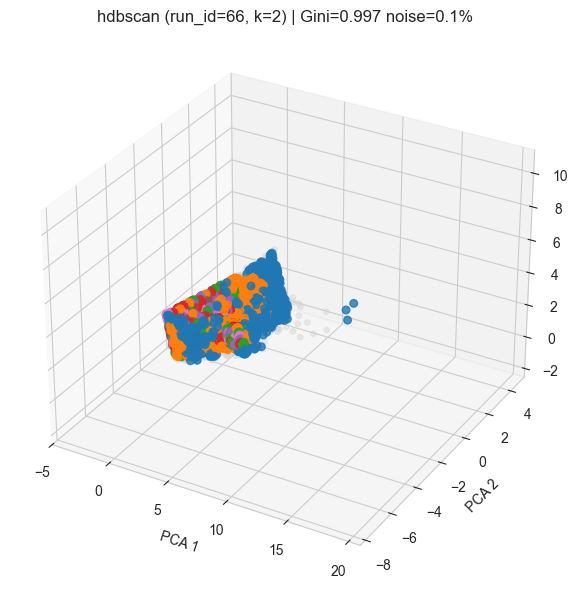

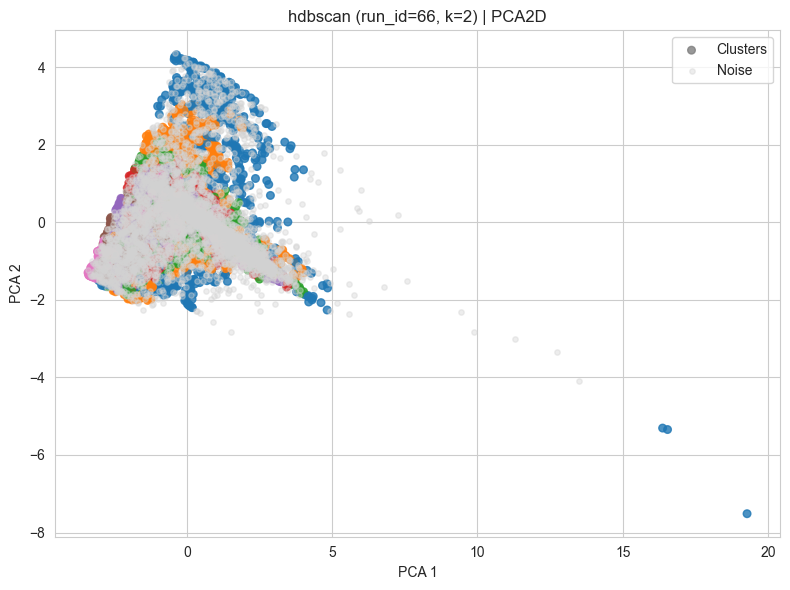

/var/folders/gb/z580gbzd2snggl2ym34nk9000000gn/T/ipykernel_77797/3418133582.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


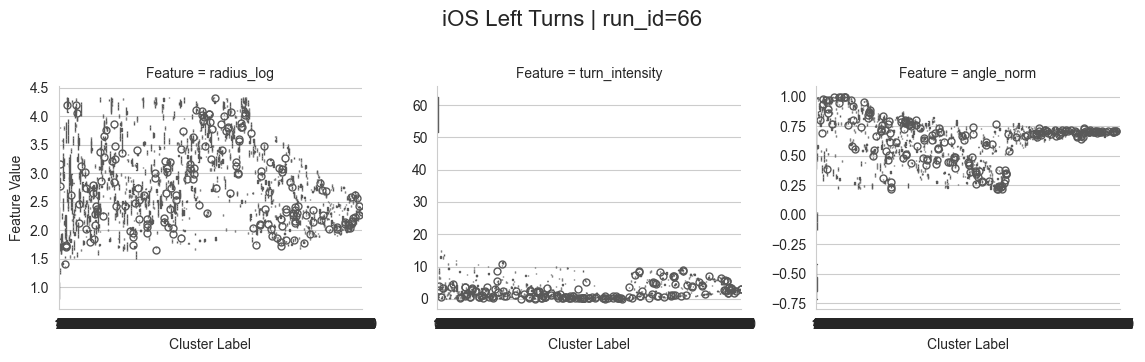

In [28]:
# --- CONFIG ---
runs_to_plot = [66]          # run_id values you care about
plot_cols = ['gyroAngleChange',
             'gyro_angular_change_per_second',
             'radius_log',
             'turn_intensity',
             'angle_norm']

# --- helpers ---------------------------------------------------------------
def build_clusterer(row):
    model = row['model']

    if model == 'kmeans':
        return KMeans(
            n_clusters=int(row['clust. #']),
            random_state=42
        )

    if model == 'dbscan':
        return DBSCAN(
            eps=float(row['HP (eps)']),
            min_samples=int(row['HP (min_samp)']),
            n_jobs=-1
        )

    if model == 'hdbscan':
        # --- FIX: ensure integers and safe defaults ---
        # min_samples
        raw_min_samples = row.get('HP (min_samp)', None)
        if pd.isna(raw_min_samples) or raw_min_samples is None:
            min_samples = 5
        else:
            min_samples = int(raw_min_samples)

        # min_cluster_size
        raw_min_clust = row.get('HP (min_clust)', None)
        if pd.isna(raw_min_clust) or raw_min_clust is None:
            min_cluster_size = min_samples
        else:
            min_cluster_size = int(raw_min_clust)

        # HDBSCAN requires strictly positive integers
        if min_samples < 1:
            min_samples = 1
        if min_cluster_size < 1:
            min_cluster_size = min_samples

        return hdbscan.HDBSCAN(
            min_samples=min_samples,
            min_cluster_size=min_cluster_size
        )

    raise ValueError(f"Unknown model '{model}' for run_id {row['run_id']}")

def attach_clusters(labels):
    df_with_clusters = full_df.copy()
    df_with_clusters['Cluster_Label'] = labels
    return df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()

# --- 1) filter the runs once -----------------------------------------------
runs = (
    filtered_results
    .loc[filtered_results['run_id'].isin(runs_to_plot)]
    .copy()
)
if runs.empty:
    raise ValueError(f"No rows found for run_id(s) {runs_to_plot}")

# fit each clusterer exactly once and cache its labels
run_labels = {}
for _, row in runs.iterrows():
    clusterer = build_clusterer(row)
    run_labels[row['run_id']] = clusterer.fit_predict(X_scaled)

# --- 2) PCA plots ----------------------------------------------------------
pca3 = PCA(n_components=3).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_scaled)

for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    core_mask = labels != -1
    noise_mask = labels == -1
    title_bits = f"{row['model']} (run_id={run_id}, k={row['clust. #']})"

    # 3D
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca3[core_mask, 0], pca3[core_mask, 1], pca3[core_mask, 2],
               c=labels[core_mask], cmap='tab10', s=30, alpha=0.8)
    if noise_mask.any():
        ax.scatter(pca3[noise_mask, 0], pca3[noise_mask, 1], pca3[noise_mask, 2],
                   c='lightgray', s=15, alpha=0.4, label='Noise')
    ax.set_title(f"{title_bits} | Gini={row['Gini']:.3f} noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
    plt.tight_layout(); plt.show()

    # 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(pca2[core_mask, 0], pca2[core_mask, 1],
                c=labels[core_mask], cmap='tab10', s=30, alpha=0.8, label='Clusters')
    if noise_mask.any():
        plt.scatter(pca2[noise_mask, 0], pca2[noise_mask, 1],
                    c='lightgray', s=15, alpha=0.4, label='Noise')
    plt.title(f"{title_bits} | PCA2D")
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.tight_layout(); plt.show()

# --- 3) Box plots ----------------------------------------------------------
for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    df_plot = attach_clusters(labels)
    df_plot['Cluster_Label'] = df_plot['Cluster_Label'].astype('category')

    melt_cols = [c for c in plot_cols if c in df_plot.columns]
    if not melt_cols:
        raise ValueError("No overlap between plot_cols and df columns.")

    df_melted = df_plot[['Cluster_Label'] + melt_cols].melt(
        id_vars='Cluster_Label', var_name='Feature', value_name='Value'
    )

    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df_melted,
        x='Cluster_Label',
        y='Value',
        col='Feature',
        kind='box',
        col_wrap=3,
        palette='Set2',
        sharey=False,
        height=3.5,
        aspect=1.1
    )
    g.fig.suptitle(f'iOS Left Turns | run_id={run_id}', y=1.02, fontsize=16)
    g.set_axis_labels('Cluster Label', 'Feature Value')
    plt.tight_layout()
    plt.show()


Graph points with Folium Library

In [29]:
# --- CONFIG ---
run_id = 66  # <-- change to your target run
gps_cols = ['eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude']

# --- 0) Safety checks ---
assert 'run_id' in filtered_results.columns, "No run_id column in filtered_results. Did you reset_index() earlier?"
assert all(c in full_df.columns for c in gps_cols), "GPS columns not found in fulldf."

# --- 1) Select the run row ---
sel = filtered_results.loc[filtered_results['run_id'] == run_id]
if sel.empty:
    raise ValueError(f"run_id {run_id} not found in filtered_results.")
row = sel.iloc[0]
model = row['model']

# --- 2) Rebuild the exact clusterer ---
if model == 'dbscan':
    eps = float(row['HP (eps)'])
    min_samp = int(row['HP (min_samp)'])
    clusterer = DBSCAN(eps=eps, min_samples=min_samp)
elif model == 'hdbscan':
    min_samp = int(row['HP (min_samp)'])
    min_clust = int(row['HP (min_clust)']) if pd.notna(row.get('HP (min_clust)')) else None
    clusterer = hdbscan.HDBSCAN(min_samples=min_samp, min_cluster_size=min_clust)
elif model == 'kmeans':
    nclust = int(row['clust. #'])
    clusterer = KMeans(n_clusters=nclust, random_state=42)
else:
    raise ValueError(f"Unknown model '{model}'")

# --- 3) Fit on the SAME X_scaled used for that run ---
# (assumes X_scaled aligns 1:1 with df's index)
labels = clusterer.fit_predict(X_scaled)

# --- 4) Build a fresh frame with labels (don't mutate df) ---
df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels

# --- 5) Reattach GPS by index (no reorder) ---
#df_with_clusters = df_with_clusters.join(full_df[gps_cols])

# --- 6) Optional: drop noise & rows missing GPS ---
plot_df = df_with_clusters.copy()
plot_df = plot_df[plot_df['Cluster_Label'] != -1]  # uncomment to hide noise
plot_df = plot_df.dropna(subset=gps_cols)

# --- 7) Sanity checks ---
assert 'Cluster_Label' in plot_df.columns, "Cluster_Label not present after join."
assert plot_df.shape[0] > 0, "No rows to plot (check GPS availability / noise filter)."

print("Ready: df_with_clusters has labels + GPS. Rows:", df_with_clusters.shape[0])
print("Plot rows:", plot_df.shape[0])
print("Features", plot_df.columns.tolist())

/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Min samples and min cluster size must be integers!